# **Keras 예제 - Seq2Seq 로 덧셈 구현**

출처 : https://github.com/keras-team/keras/blob/2.0.0/examples/addition_rnn.py


In [1]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs
'''

'An implementation of sequence to sequence learning for performing addition\nInput: "535+61"\nOutput: "596"\nPadding is handled by using a repeated sentinel character (space)\nInput may optionally be inverted, shown to increase performance in many tasks in:\n"Learning to Execute"\nhttp://arxiv.org/abs/1410.4615\nand\n"Sequence to Sequence Learning with Neural Networks"\nhttp://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf\nTheoretically it introduces shorter term dependencies between source and target.\nTwo digits inverted:\n+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs\nThree digits inverted:\n+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs\nFour digits inverted:\n+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs\nFive digits inverted:\n+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs\n'

In [1]:
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12347039164588220290,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9685238792985924583
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10699354944
 locality {
   bus_id: 4
   numa_node: 3
   links {
   }
 }
 incarnation: 5228347648819362406
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:07:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10699354944
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 16929413696462236531
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13692164121298709924
 physi

In [3]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    # 초기화 : 사용되는 문자 집합이 주어지면 caharacter table 을 초기화한다.
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        # 문자 집합이 주어지면 각 문자에 대한 인덱스를 매긴다.
        # char_indices : (문자, 인덱스), indices_char : (인덱스, 문자)
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        # 문장(C)의 문자에 해당하는 행렬 위치를 0->1 로 바꾼다.
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1    # 순서대로 i번째 행에 char_indices[c] 열에 1 대입
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [4]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [5]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAxLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
# ctable : 문자 집합에 대해 character table 을 만든 인스턴스(?)
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
file_path = 'dataset/addition.txt'

print('Get data...from txt')
for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx][::-1])
        expected.append(line[idx+1:-1])
        
#print('Generating data...')
# np.random.randint(1, 20) : 1~19까지 랜덤한 숫자 1개
#while len(questions) < TRAINING_SIZE:
#    # f : 최대 3자리까지 랜덤한 숫자를 만든다.
#    f = lambda: int(''.join(np.random.choice(list('0123456789'))
#                    for i in range(np.random.randint(1, DIGITS + 1))))
#    a, b = f(), f()

#    # Skip any addition questions we've already seen
#    # Also skip any such that x+Y == Y+x (hence the sorting).
#    key = tuple(sorted((a, b)))
#    if key in seen:
#        continue
#    seen.add(key)

#    # Pad the data with spaces such that it is always MAxLEN.
#    q = '{}+{}'.format(a, b)
#    query = q + ' ' * (MAxLEN - len(q)) # 전체 길이 - q 길이 만큼 padding 을 줘서 전체 길이가 맞춰지도록.
#    ans = str(a + b)

#    # Answers can be of maximum size DIGITS + 1.
#    # answer 도 패딩을 맞춰준다. (answer가 될 수 있는 최대 길이에서 - 현재 나온 답의 길이 만큼)
#    ans += ' ' * (DIGITS + 1 - len(ans))

#    # Input의 Reverse 여부
#    if INVERT:
#        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
#        # space used for padding.)
#        query = query[::-1] # Reverse
#    questions.append(query)
#    expected.append(ans)
print('Total addition questions:', len(questions))

Get data...from txt
Total addition questions: 50000


In [6]:
print('Vectorization...')
# np.zeros(shape, dtype, order)
x = np.zeros((len(questions), MAxLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
print(x.shape)
print(y.shape)

Vectorization...
(50000, 7, 12)
(50000, 4, 12)


In [7]:
print(questions[0])
print(expected[0])

  57+61
91  


In [8]:
print('Vectorization...')
# np.zeros(shape, dtype, order)
# x : (50000, 7, 12), y : (50000, 4, 12)
# 입력데이터를 Encode
x = np.zeros((len(questions), MAxLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAxLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
# x의 뒷부분이 더 커지기 때문에 (x, y) 를 섞는다. (???) -> 어쨋든 셔플
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
# Test Set : 0~45000, Validation Set : 45000~50000
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [9]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAxLEN, len(chars))))

# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))

# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    # return_sequences(시퀀스 출력 여부): True(각 시퀀스에서 출력, many-to-many 일 때)
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
# TimeDistributed :7개의 시간 단계 각각에 독립적으로 Dense 레이어를 적용
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 12)             1548      
_________________________________________________________________
activation (Activation)      (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model each generation and show predictions against the validation
# dataset.
acc_list = []
history_list = []

for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    history_list.append(history.history.get('val_accuracy')[0])
    
    correct_num = 0
    for i in range(len(x_val)):
        rowx, rowy = x_val[np.array([i])], y_val[np.array([i])]
        # predict_classes : 0 or 1로 출력 (predict 와 약간 다름) --> 2.6버전에서 삭제됨
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        
        if guess == correct:
          correct_num += 1
        else:
          correct_num += 0
        
#        if correct == guess:
#            print(colors.ok + '☑' + colors.close, end=" ")
#        else:
#            print(colors.fail + '☒' + colors.close, end=" ")
#        print(guess)
#        print('---')
    acc = float(correct_num) / len(x_val)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    if iteration == 100:
      print('100번째 정확도 : ', acc)
    
model.save('addition.h5')


--------------------------------------------------
Iteration 1
352/352 [==============================] - 2s 6ms/step - loss: 1.0052 - accuracy: 0.6349 - val_loss: 1.0021 - val_accuracy: 0.6201


KeyboardInterrupt: 

/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50

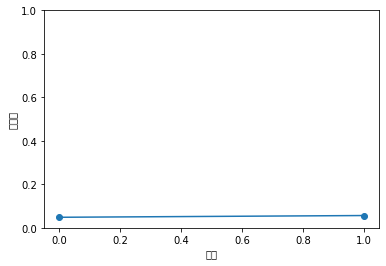

In [45]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tako/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50

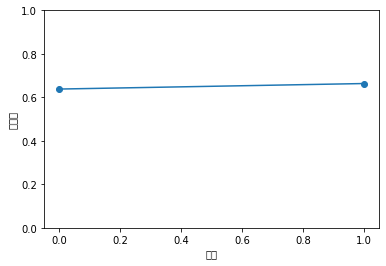

In [46]:
# 그래프 그리기
v = np.arange(len(history_list))
plt.plot(v, history_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

In [ ]:
## summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()